In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import pysindy as ps
import matplotlib.pyplot as plt
import torch

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

from utils.translation_utils import *
from utils.decomposition_utils import *

warnings.filterwarnings('ignore')

In [12]:
import torch
import pandas as pd
df1 = torch.load('../../tb_logs/VAE_Evolver_cadCyt_beta=0.ckpt', map_location='cpu')['val_df'].loc[:, ['embryoID', 'time']]
df2 = torch.load('../../tb_logs/VAE_Evolver_cadRaw_beta=0.ckpt', map_location='cpu')['val_df'].loc[:, ['embryoID', 'time']]
print(df1.equals(df2))

True


Text(0, 0.5, 'Error Rate')

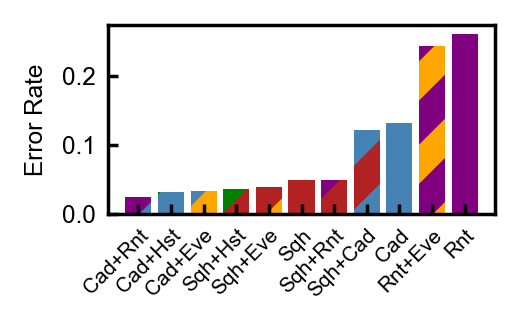

In [8]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['xtick.major.width'] = 1.
plt.rcParams['ytick.major.width'] = 1.
plt.rcParams['xtick.major.size'] = 3.
plt.rcParams['ytick.major.size'] = 3.
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['hatch.linewidth'] = 8.0

logdir = '../../tb_logs'
data = pd.DataFrame(columns=['inputs', 'loss'])

for d in glob.glob(os.path.join(logdir, 'VAE_Evolver_*_vel')):
    if '[' in d: continue
    info = torch.load(os.path.join(d, 'beta=0.ckpt'), map_location='cpu')
    data = data.append({
        'inputs': '+'.join(info['hparams']['input']).title(),
        'loss': info['loss']
    }, ignore_index=True)
#data.loc[data['inputs'].str.contains('Cad\+'), 'loss'] *= 2
#data.loc[data['inputs'].str.contains('Sqh\+'), 'loss'] *= 2
data = data.set_index('inputs')
#data.loc['Cad', 'loss'] *= 0.1
#data.loc['Sqh+Cad', 'loss'] *= 0.1 / 2
data = data.sort_values('loss')
data = data.reset_index()

data.loc[data.loss < 0.1, 'loss'] *= 3

colors = {
    'Sqh': 'firebrick',
    'Cad': 'steelblue',
    'Rnt': 'purple',
    'Eve': 'orange',
    'Hst': 'green'
}

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(2, 1))
for i in range(len(data)):
    labels = data.iloc[i].inputs.split('+')
    if len(labels) == 1:
        ax.bar(i, data.loss[i], facecolor=colors[labels[0]])
    else:
        ax.bar(i, data.loss[i], 
               facecolor=colors[labels[0]], edgecolor=colors[labels[1]],
               hatch='/', lw=0)
ax.set_xticks(np.arange(len(data)))
ax.set_xticklabels(data.inputs, rotation=45, 
                   fontsize=6, rotation_mode='anchor', ha='right');
ax.set_ylabel('Error Rate')

In [3]:
from utils.dataset import *
from torchvision.transforms import Compose
from atlas_processing.anisotropy_detection import cell_size
transform = Reshape2DField()
sqh_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'tensor2D', 
                           transform=Compose([transform, ToTensor()]), drop_time=True)
cad_dataset =  AtlasDataset('WT', 'ECad-GFP', 'cyt2D', 
                            transform=Compose([transform, Smooth2D(sigma=cell_size), ToTensor()]))
sqh_vel_dataset = AtlasDataset('Halo_Hetero_Twist[ey53]_Hetero', 'Sqh-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]), drop_time=True)
cad_vel_dataset = AtlasDataset('WT', 'ECad-GFP', 'velocity2D', 
                               transform=Compose([transform, ToTensor()]))


runt_dataset = AtlasDataset('WT', 'Runt', 'raw2D', 
                            transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]))
hist_dataset = AtlasDataset('WT', 'histone-RFP', 'raw2D', 
                            transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]), drop_time=True,)
eve_dataset = AtlasDataset('WT', 'Even_Skipped', 'raw2D', 
                           transform=Compose([transform, Smooth2D(sigma=3), ToTensor()]), drop_time=True)

100%|██████████| 1/1 [00:00<00:00, 12.58it/s]


embryoID ()
time ()
c torch.Size([1, 236, 200])
v torch.Size([2, 236, 200])
m_ij torch.Size([4, 236, 200])
Rnt torch.Size([1, 236, 200])
Eve torch.Size([1, 236, 200])


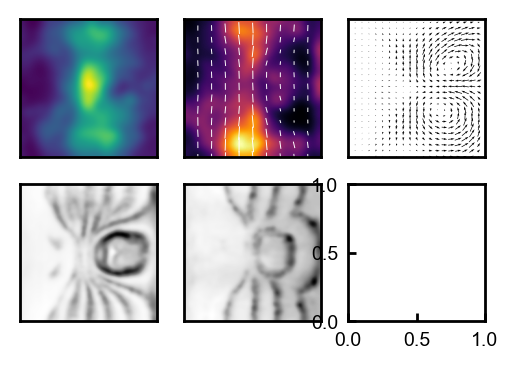

In [7]:
from utils.dataset import JointDataset
dataset = JointDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('v', cad_vel_dataset),
    ('Rnt', runt_dataset),
    ('Eve', eve_dataset),
], 
ensemble=2)

batch = dataset[120]
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])

from utils.plot_utils import *
fig, ax = plt.subplots(2, 3, dpi=200, figsize=(3, 2))
color_2D(ax[0, 0], batch['c'], cmap='viridis')
plot_tensor2D(ax[0, 1], batch['m_ij'].numpy(), cmap='inferno')
plot_vector2D(ax[0, 2], batch['v'])

color_2D(ax[1, 0], batch['Rnt'], cmap='Greys')
color_2D(ax[1, 1], batch['Eve'], cmap='Greys')


for a in ax.flatten():
    a.set_aspect('auto')

In [20]:
from utils.dataset import TrajectoryDataset
dataset = TrajectoryDataset([
    ('m_ij', sqh_dataset),
    ('v', sqh_vel_dataset),
    ('c', cad_dataset),
    ('v', cad_vel_dataset),
    ('Rnt', runt_dataset),
    ('Hst', hist_dataset),
    ('Eve', eve_dataset),
], 
ensemble=2)

print(len(dataset))
        
loader = torch.utils.data.DataLoader(dataset, batch_size=8, num_workers=0, collate_fn=dataset.collate_fn)
batch = next(iter(loader))
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(key, batch[key])
x = torch.cat(
    [batch[i][:, 0] for i in ['m_ij', 'c']],
    dim=-3)
print(x.shape)

866
embryoID torch.Size([8, 8])
lengths [3, 5, 8, 3, 3, 2, 4, 2]
time torch.Size([8, 8])
c torch.Size([8, 8, 1, 236, 200])
v torch.Size([8, 8, 2, 236, 200])
m_ij torch.Size([8, 8, 4, 236, 200])
Rnt torch.Size([8, 8, 1, 236, 200])
Hst torch.Size([8, 8, 1, 236, 200])
Eve torch.Size([8, 8, 1, 236, 200])
torch.Size([8, 5, 236, 200])


In [163]:
for batch in tqdm(loader):
    pass

100%|██████████| 963/963 [03:07<00:00,  5.14it/s]


In [119]:
from convnext_models import *

beta=0
info = torch.load('../../tb_logs/VAE_Evolver_[\'sqh\', \'cad\']_vel/beta=%.2g.ckpt' % beta)
print(info['loss'])
model = VAE_Evolver(**info['hparams'])
model.load_state_dict(info['state_dict'])

0.03183893850919876


<All keys matched successfully>

In [120]:
dataset.ensemble = 6

def ensemble_key(dataset, key, time):
    df = dataset.df[dataset.df.key == key]
    nearest = df[(df.time - time).abs() < 1]

    frame = []
    for i, row in nearest.iterrows():
        data = dataset.values[row.embryoID][key][row.eIdx]
        if dataset.transforms[row.dataset_idx] is not None:
            data = dataset.transforms[row.dataset_idx](data)
        frame.append(data)

    if torch.is_tensor(frame[0]):
        frame = torch.mean(torch.stack(frame), dim=0)
    elif isinstance(frame[0], np.ndarray):
        frame = np.mean(np.stack(frame), axis=0)

    return frame

def get_ensemble_trajectory(dataset, tmin, tmax):
    times = np.arange(tmin, tmax, dtype=int)
    sample = {}
    for key in dataset.keys:
        sample[key] = []
        for t in times:
            sample[key].append(ensemble_key(dataset, key, t))
    
        sample[key] = torch.stack(sample[key], dim=0)
    sample['time'] = times
    return sample

batch = get_ensemble_trajectory(dataset, -10, 11)
for key in batch:
    try:
        print(key, batch[key].shape)
    except:
        print(batch[key])

m_ij torch.Size([21, 4, 236, 200])
v torch.Size([21, 2, 236, 200])
c torch.Size([21, 1, 236, 200])
time (21,)


In [121]:
device = torch.device('cuda:0')
model.eval()
model.to(device)
with torch.no_grad():
    x = torch.cat([batch['m_ij'], batch['c']], dim=1)
    y0 = batch['v']
    y, pl = model(x[0:1].to(device), [x.shape[0]])
    y = y[0].cpu().numpy()
    y0 = y0.cpu().numpy()
    x = x.cpu().numpy()
    print(x.shape, y0.shape, y.shape)

(21, 5, 236, 200) (21, 2, 236, 200) (21, 2, 236, 200)


Text(0, 0.5, 'Flow (RNN)')

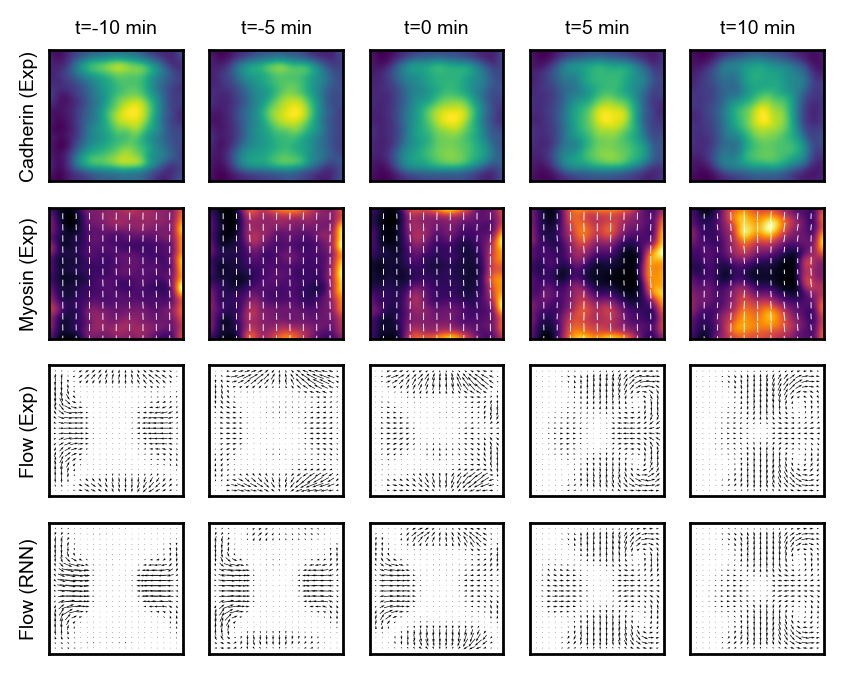

In [122]:
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['axes.titlesize'] = 8

fig, ax = plt.subplots(4, 5, dpi=200, figsize=(5, 4))
dt=5
for i in range(5):
    ii = i*dt
    ax[0, i].set_title('t=%d min' % batch['time'][ii], fontsize=7)
    color_2D(ax[0, i], x[ii, -1], cmap='viridis')
    plot_tensor2D(ax[1, i], x[ii, :-1], cmap='inferno')
    plot_vector2D(ax[2, i], y0[ii])
    plot_vector2D(ax[3, i], y[ii])
    
for a in ax.flatten():
    a.set_aspect('auto')
    
ax[0, 0].set_ylabel('Cadherin (Exp)')
ax[1, 0].set_ylabel('Myosin (Exp)')
ax[2, 0].set_ylabel('Flow (Exp)')
ax[3, 0].set_ylabel('Flow (RNN)')

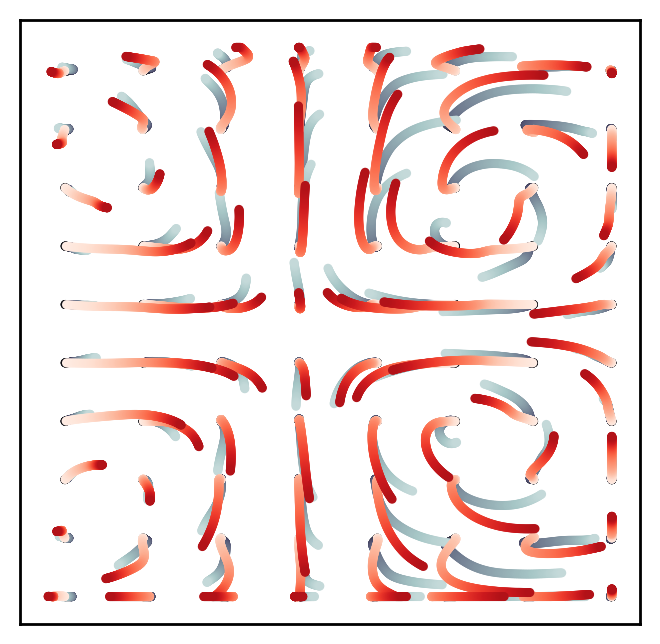

In [110]:
#Demonstrate ensemble of cell trajectories
plt.rcParams['font.size'] = 8
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['axes.linewidth'] = 1.
plt.rcParams['axes.titlesize'] = 8


from math import floor, ceil
from scipy.interpolate import RectBivariateSpline as interp2d

def get_velocity(v, tt, X0, Y0, x, y):
    idxA, idxB = floor(tt), ceil(tt)
    frac = 1 - (tt - idxA)
    vA, vB = v[idxA], v[idxB]
        
    vx = interp2d(Y0, X0, frac * vA[1] + (1 - frac) * vB[1])(y, x, grid=False)
    vy = interp2d(Y0, X0, frac * vA[0] + (1 - frac) * vB[0])(y, x, grid=False)
    return vx, vy

def rk4DynamicVelocity2D(pts, X0v, Y0v, v, hh):
    tt = np.arange(0, v.shape[0]-1, hh)
    xyPathsMat = np.zeros([pts.shape[0], len(tt), 2])

    x = pts[:, 0]
    y = pts[:, 1]
    xyPathsMat[:, 0, 0] = x
    xyPathsMat[:, 0, 1] = y
    
    Xmin, Xmax = X0v[0], X0v[-1]
    Ymin, Ymax = Y0v[0], Y0v[-1]
    
    for ii in range(len(tt) - 1):
        k1x, k1y = get_velocity(v, tt[ii], X0v, Y0v, x, y)
        k2x, k2y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k1x, y + 0.5 * hh * k1y)
        k3x, k3y = get_velocity(v, tt[ii] + 0.5 * hh, X0v, Y0v, x + 0.5 * hh * k2x, y + 0.5 * hh * k2y)
        k4x, k4y = get_velocity(v, tt[ii] + hh, X0v, Y0v, x + hh * k3x, y + hh * k3y)
        
        #Main equation
        x = x + (k1x + 2 * k2x + 2 * k3x + k4x) * hh / 6.
        y = y + (k1y + 2 * k2y + 2 * k3y + k4y) * hh / 6.
        
        x[x > Xmax] = Xmax
        x[x < Xmin] = Xmin
        y[y > Ymax] = Ymax
        y[y < Ymin] = Ymin
        
        xyPathsMat[:, ii, 0] = x
        xyPathsMat[:, ii, 1] = y
            
    return xyPathsMat

from scipy.io import loadmat
px = loadmat('/project/vitelli/jonathan/fruitfly/flydrive.synology.me/minimalData/vitelli_sharing/pixel_coordinates.mat')
X0, Y0 = px['XX'], px['YY']

X0 = X0 * 0.2619 / 0.4 #Convert pixels to microns
Y0 = Y0 * 0.2619 / 0.4 #Convert pixels to microns

hh = 0.2
sub = 25
pts = np.stack([X0[::-sub, ::-sub].flatten(), 
                Y0[::sub, ::sub].flatten()], axis=-1).reshape([-1, 2])

fig, ax = plt.subplots(1, 1, dpi=200, figsize=(4, 4))

labels = ['Experiment', 'ML']
cmaps = [
    'bone',
    'Reds',
]

for i, v, in enumerate([y0, y]):
    xyPathsMat = rk4DynamicVelocity2D(pts, X0[0], Y0[:, 0], v, hh)
    nPts = xyPathsMat.shape[0]
    nTps = xyPathsMat.shape[1]
    for tpId in range(nTps-1):
        ax.scatter(xyPathsMat[:, tpId, 0], xyPathsMat[:, tpId, 1], s=5, 
                   c=np.ones(nPts)*tpId, 
                   cmap=cmaps[i], vmin=-10, vmax=nTps*1.2)
        
ax.set(xticks=[], yticks=[])

plt.savefig('../Figures/RNN_Forecasting.png', dpi=350, bbox_inches='tight')